In [1]:
import csv
import sys
from pytorch_transformers import BertTokenizer
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def subtask(s):
    ts = [BOS] + _tokenizer.tokenize(s) + [EOS]
    idxs = _tokenizer.convert_tokens_to_ids(ts)
    return idxs

class Processor:
    def __init__(self, name, threads):
        lines = self.readcsv(name)
        # 0, 6, 8, 9
        #self.id = [] 
        self.score = []
        self.summary = []
        self.text = []
        #self.data = []
        self.n_worker = threads
        
        for d in lines[1:]:
            self.score.append(int(d[6]) > 3) # convert to 0/1
            self.summary.append(d[8])
            self.text.append(d[9].strip("\""))
        self.size = len(self.text)   
    
    def convert_all_to_ids(self):
        if self.n_worker > 1:
            with Pool(self.n_worker) as p:
                chunksize = 100
                sumseqs = list(tqdm(p.imap(subtask, self.summary, chunksize=chunksize), total=self.size))
        else:
            sumseqs = [subtask(s) for s in tqdm(self.summary)]
        if self.n_worker > 1:
            with Pool(self.n_worker) as p:
                chunksize = 100
                tseqs = list(tqdm(p.imap(subtask, self.text, chunksize=chunksize), total=self.size))
        else:
            tseqs = [subtask(s) for s in tqdm(self.text)]
        self.textseqs = tseqs
        self.sumseqs = sumseqs
        
    def __len__(self):
        return self.size
    
    @staticmethod
    def readcsv(input_file, quotechar="\""):
        """Reads a comma separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter=",", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines

In [2]:
p = Processor("data/Reviews.csv", threads=12)

In [ ]:
p.convert_all_to_ids()

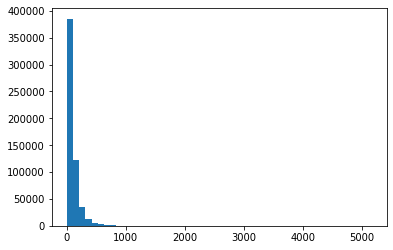

In [6]:
from matplotlib import pyplot as plt
lplot = [len(s) for s in p.textseqs]
plt.hist(lplot, bins=50)
plt.show()

In [8]:
import numpy as np
mean = np.mean(lplot)
std = np.std(lplot)
print(mean,std) 

108.63102027604697 112.60247091866304


In [10]:
import json
seqdata = {"text":p.textseqs, "summary":p.sumseqs, "score":p.score}
json.dump(seqdata, open("data.json", 'w'))

In [11]:
json.dump(_tokenizer.vocab, open("vocab.json", "w"))

In [12]:
len(_tokenizer.vocab)

30522